In [17]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np

# Paths
base_dir = "lung"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Val")
test_dir = os.path.join(base_dir, "Test")

# Image parameters
IMG_SIZE = (224, 224)  # Resize images to 224x224
BATCH_SIZE = 16

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data loaders
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

val_data = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

test_data = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# Load the MobileNet model pre-trained on ImageNet without the top layer (classification head)
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a GlobalAveragePooling2D layer to get the feature map
x = mobilenet.output
x = GlobalAveragePooling2D()(x)

# Create the model
feature_extractor = Model(inputs=mobilenet.input, outputs=x)

# Function to extract features
def extract_features(data_gen):
    features = []
    labels = []
    for batch in data_gen:
        # Extract features from the batch
        feature_batch = feature_extractor.predict(batch[0])
        features.append(feature_batch)
        labels.append(batch[1])
        # Stop if all data is processed
        if len(features) * BATCH_SIZE >= data_gen.samples:
            break
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features from training, validation, and test data
train_features, train_labels = extract_features(train_data)
val_features, val_labels = extract_features(val_data)
test_features, test_labels = extract_features(test_data)

# Print out the shapes of the extracted features
print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


Found 11250 images belonging to 3 classes.
Found 1875 images belonging to 3 classes.
Found 1875 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━

In [ ]:


# Reshaping the feature data
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)



In [ ]:
# Encode labels as integers for classification models
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(np.argmax(train_labels, axis=1))  # One-hot to integer
val_labels = label_encoder.transform(np.argmax(val_labels, axis=1))
test_labels = label_encoder.transform(np.argmax(test_labels, axis=1))

In [7]:
# Define individual models
svm_model = SVC(kernel='linear', probability=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Create an ensemble model using VotingClassifier (soft voting)
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('rf', rf_model),
    ('lr', lr_model)
], voting='soft')


In [8]:
# Cross-validation on the ensemble model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation on features and labels
cv_scores = cross_val_score(ensemble_model, train_features, train_labels, cv=cv, scoring='accuracy')


c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
# Print cross-validation results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores)}")
print(f"Standard deviation of CV accuracy: {np.std(cv_scores)}")

Cross-validation accuracy scores: [0.96711111 0.97466667 0.96222222 0.96444444 0.96933333]
Mean CV accuracy: 0.9675555555555555
Standard deviation of CV accuracy: 0.004290673203963453


In [10]:
# Train the ensemble model on the full training data
ensemble_model.fit(train_features, train_labels)

VotingClassifier(estimators=[('svm', SVC(kernel='linear', probability=True)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [11]:
# Evaluate on validation and test data
val_preds = ensemble_model.predict(val_features)
test_preds = ensemble_model.predict(test_features)

In [ ]:
# Ensure class labels are converted to strings
class_names = [str(label) for label in label_encoder.classes_]

In [39]:
# Print classification report for validation and test sets
print("Validation Set Classification Report:")
print(classification_report(val_labels, val_preds, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Validation Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.98      0.94      0.96       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.95      0.99      0.97       625

          accuracy                           0.98      1875
         macro avg       0.98      0.98      0.98      1875
      weighted avg       0.98      0.98      0.98      1875



In [38]:
print("Test Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Test Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.99      0.93      0.96       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.93      0.99      0.96       625

          accuracy                           0.97      1875
         macro avg       0.97      0.97      0.97      1875
      weighted avg       0.97      0.97      0.97      1875



In [18]:
# Compute confusion matrix for validation and test sets
val_conf_matrix = confusion_matrix(val_labels, val_preds)
test_conf_matrix = confusion_matrix(test_labels, test_preds)

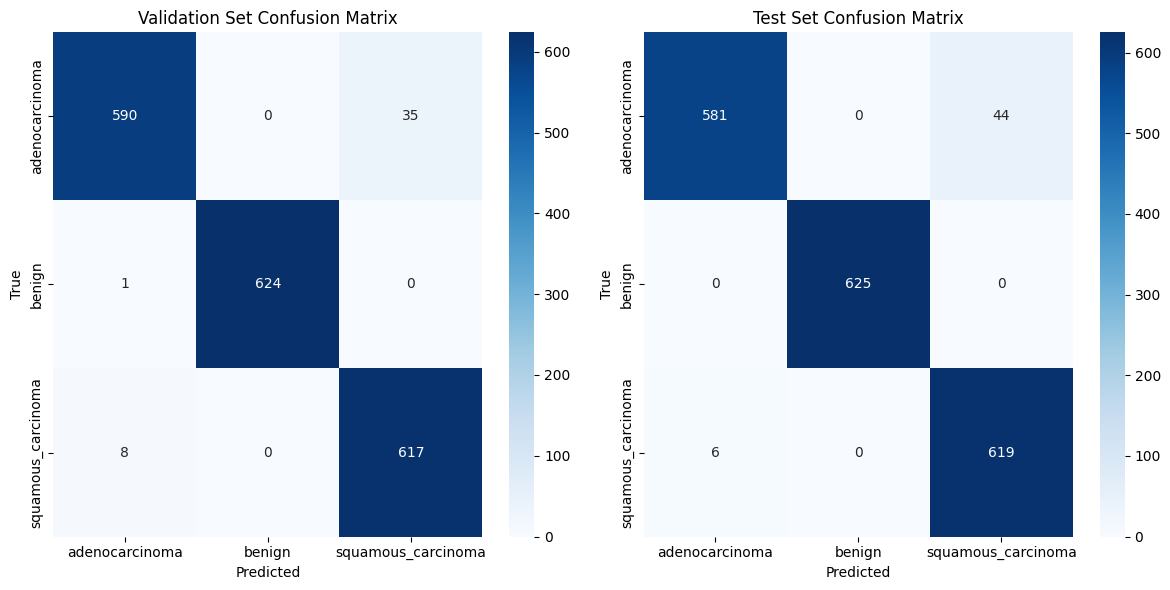

In [37]:

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


In [20]:
import joblib

# Save the trained ensemble model
joblib.dump(ensemble_model, 'ensemble_model.joblib')


['ensemble_model.joblib']

In [21]:
# Load the saved model
ensemble_model = joblib.load('ensemble_model.joblib')


In [22]:
# Save the feature extraction model
feature_extractor.save('feature_extractor_model.h5')


In [23]:
from tensorflow.keras.models import load_model

# Load the saved feature extraction model
feature_extractor = load_model('feature_extractor_model.h5')


In [36]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import joblib

# Load the saved feature extraction model
feature_extractor = load_model('feature_extractor_model.h5')

# Load the saved ensemble model
ensemble_model = joblib.load('ensemble_model.joblib')

# Class names
class_names = ['adenocarcinoma', 'benign', 'squamous_carcinoma']

# Image preprocessing function for feature extraction
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img, target_size)  # Resize image
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    img_resized = img_resized / 255.0  # Normalize
    return img_resized

# Function to extract features from a single image
def extract_features_from_image(img_path):
    img_preprocessed = preprocess_image(img_path)
    features = feature_extractor.predict(img_preprocessed)
    return features

# Make a prediction on a single image
def predict_image(img_path):
    # Extract features from the image
    features = extract_features_from_image(img_path)
    features = features.reshape(1, -1)  # Flatten the feature map

    # Predict using the ensemble model
    prediction = ensemble_model.predict(features)

    return prediction

# Path to the image you want to predict
image_path = r'lung\Test\benign\lungn4386.jpeg'  # Replace with your image path

# Predict the image
prediction = predict_image(image_path)

# Get class label and class name
predicted_label = prediction[0]
predicted_class_name = class_names[predicted_label]

# Output the predicted class name
print(f"Predicted class label: {predicted_label} ({predicted_class_name})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class label: 1 (benign)
